In [14]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import numpy.random as rng
import math
import pandas as pd



# Hyperparameters
my_s1 = 25
my_s2 = 25
var_s1 = 25/3
var_s2 = 25/3
var_t = 25/3

t_guess = 1 #unknown t in mean vector, init guess

# 2D case
my_S = [my_s1, my_s2]
sigma_s = [[var_s1, 0], [0, var_s2]]
sigma_t = var_t

# Samples
num_samples = 10200
s_sample = np.zeros((num_samples, 2))
t_sample = np.zeros(num_samples)

# Task specifik covariance matrix
#det_T = 1/((1/var_s1+1/var_t)*(1/var_s2+1/var_t)-1/var_t**2)

# Gibbs Sampler
# Calculate my using corolary 1 

def update_my(t, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T):
    return Sigma_T@np.array([[my_s1/var_s1 + t/var_t], [my_s2/var_s1 - t/var_t]])

# Gibbs Sampler function
# s_sample and t_ sample are two/one dimentional vectors storing the values calculated 
def gibbs_sample(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T, s_sample, t_sample, y, num_samples):
    my = update_my(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T)
    s_sample[0] = rng.multivariate_normal(my.T[0], sigma_s)
    t_sample[0] = t_guess
    a = -math.inf
    b = 0
    if(y > 0):
        a = 0
        b = math.inf
    for i in range(num_samples):
        #my_t = Sigma_T@np.array([[my_s1/var_s1 + t_sample[i-1]/var_t], [my_s2/var_s1 - t_sample[i-1]/var_t]])
        my = update_my(t_sample[i-1], my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T)
        s_sample[i] = rng.multivariate_normal(my.T[0], Sigma_T)
        t_sample[i] = sp.stats.truncnorm.rvs(a, b, s_sample[i][0]-s_sample[i][1], var_t)


NameError: name 'det_T' is not defined

In [ ]:
samples =[3200]
#Sigma_T = det_T*np.array([[1/var_s2 + 1/var_t, 1/var_t], [1/var_t, 1/var_s1 + 1/var_t]])
for sample in samples:
    s_sample = np.zeros((sample, 2))
    t_sample = np.zeros(sample)
    gibbs_sample(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T, s_sample, t_sample, 1, sample)
    s1_spred = np.mean(s_sample[200:, 0])
    s1_vpred = np.std(s_sample[200:, 0])
    s2_spred = np.mean(s_sample[200:, 1])
    s2_vpred = np.std(s_sample[200:, 1])
    x = np.linspace(0, 60, 1000)
    #plt.hist(s_sample[200:], bins=50, density=True)
    #plt.plot(x, sp.stats.norm.pdf(x, s1_spred, s1_vpred), label=sample)
    #plt.plot(x, sp.stats.norm.pdf(x, s2_spred, s2_vpred), label=sample)
    plt.plot(s_sample[:200,0])
#plt.legend()
plt.show()
    
    
# Trying to find burnin
x = list()
for i in range(int(s_sample.__len__()/10)):
    mean = sp.stats.norm.mean(t_sample[range(i, i+100)])
    x.append(mean[0])

# Burn in
b_in = 200
s1_spred = np.mean(s_sample[b_in:, 0])
s1_vpred = np.std(s_sample[b_in:, 0])
s2_spred = np.mean(s_sample[b_in:, 1])
s2_vpred = np.std(s_sample[b_in:, 1])


x = np.linspace(0, 60, 1000)
plt.hist(s_sample[200:], bins=50, density=True)
plt.plot(x, sp.stats.norm.pdf(x, s1_spred, s1_vpred))
plt.plot(x, sp.stats.norm.pdf(x, s2_spred, s2_vpred))
plt.show()

In [19]:
with open('SerieA.CSV', 'r') as f:
    A = pd.read_csv(f)
print(A)

mean_dict = dict()
std_dict = dict()

start_mean = 25
start_std = 25/3
N = 2200
# Fill dicts with team name and init values
for team in A['team1']:
    if(team not in mean_dict):
        mean_dict[team] = [start_mean]
        std_dict[team] = [start_std]


vart = 25/3
t_g = 1000
for index, row in A.iterrows():
    
    result = row['score1']-row['score2']
    if(result==0):
        print('no update, draw')       
    else:
        s_sample1 = np.zeros((N, 2))
        t_sample1 = np.zeros(N)
        my1 = mean_dict[row['team1']][-1]
        my2 = mean_dict[row['team2']][-1]
        std1 = std_dict[row['team1']][-1]
        std2 = std_dict[row['team2']][-1]
        my = [my1, my2]
        var = [[std1, 0], [0, std2]]
        det = 1/((1/std1+1/vart)*(1/std2+1/vart)-1/vart**2)
        cov = det*np.array([[1/std2 + 1/vart, 1/vart], [1/vart, 1/std2 + 1/vart]])
        gibbs_sample(t_g, my1, std1, my2, std2, vart, cov, s_sample1, t_sample1, result, N)
        
        b_in = 400

        # Calculate new mean and var
        s1spred = np.mean(s_sample1[b_in:, 0])
        s1vpred = np.std(s_sample1[b_in:, 0])
        s2spred = np.mean(s_sample1[b_in:, 1])
        s2vpred = np.std(s_sample1[b_in:, 1])
        # Insert new values in dict
        mean_dict[row['team1']].append(s1spred)
        std_dict[row['team1']].append(s1vpred)
        mean_dict[row['team2']].append(s2spred)
        std_dict[row['team2']].append(s2vpred)
        if(index%50 == 0):
            print(index)
            print(mean_dict['Juventus'])

     yyyy-mm-dd  HH:MM       team1     team2  score1  score2
0    2018-08-18  18:00      Chievo  Juventus       2       3
1    2018-08-18  20:30       Lazio    Napoli       1       2
2    2018-08-19  18:00      Torino      Roma       0       1
3    2018-08-19  20:30    Sassuolo     Inter       1       0
4    2018-08-19  20:30       Parma   Udinese       2       2
..          ...    ...         ...       ...     ...     ...
375  2019-05-26  20:30        Roma     Parma       2       1
376  2019-05-26  20:30       Inter    Empoli       2       1
377  2019-05-26  20:30  Fiorentina     Genoa       0       0
378  2019-05-26  20:30    Cagliari   Udinese       1       2
379  2019-05-26  20:30    Atalanta  Sassuolo       3       1

[380 rows x 6 columns]
0
[25, 31.710138027126362]
no update, draw
no update, draw
no update, draw
no update, draw
no update, draw
no update, draw
no update, draw
no update, draw
no update, draw
no update, draw
no update, draw
50
[25, 31.710138027126362, 34.4985645521

[8.333333333333334, 3.29966776309908, 2.101428270889548, 1.5242190826883428, 1.3099408439931892, 1.2937442142552678, 1.204973614456008, 1.1984822332720186, 1.1660870485885644, 1.246975712770862, 1.1988600464121162, 1.1974508911692217, 1.1232773731883074, 1.2149088739832519, 1.1850721389887666, 1.1597401822591777, 1.2164496413704027, 1.2115482981159935, 1.174265732657621, 1.1651496020667047, 1.1523154629161647, 1.1580932675021187, 1.174712705524452, 1.1936554994554263, 1.205385822300616, 1.1762112138250636, 1.1773811936209142, 1.203688299770511, 1.199795941982387, 1.1797740202500597, 1.2069858635903226, 1.1605457066713445, 1.2200408923676562]


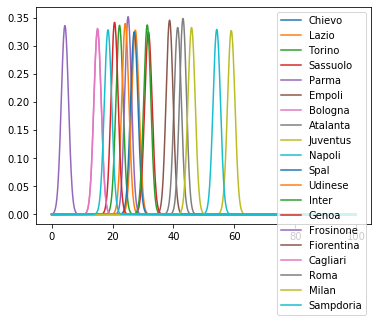

In [23]:
print(std_dict['Juventus'])
x = np.linspace(0, 100, 1000)
for team in mean_dict:
    plt.plot(x, sp.stats.norm.pdf(x, mean_dict[team][-1], std_dict[team][-1]), label=team)
plt.legend()
plt.show()